## CNN-(LSTM)

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import random
import os

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
### LOAD TRAIN ###
train_df = pd.read_csv('./PM_train.txt', sep=" ", header=None)

train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
print('#id:',len(train_df.id.unique()))
train_df = train_df.sort_values(['id','cycle'])
print(train_df.shape)
train_df.head(3)

FileNotFoundError: ignored

# New section

medium working time: 206.31
max working time: 362
min working time: 128


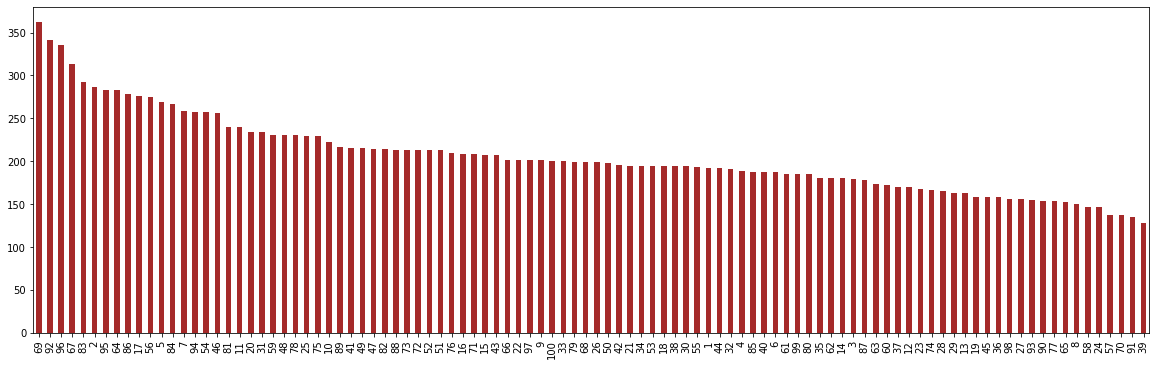

In [ ]:

plt.figure(figsize=(20,6))
train_df.id.value_counts().plot.bar(color=('brown'))
print("medium working time:", train_df.id.value_counts().mean())
print("max working time:", train_df.id.value_counts().max())
print("min working time:", train_df.id.value_counts().min())

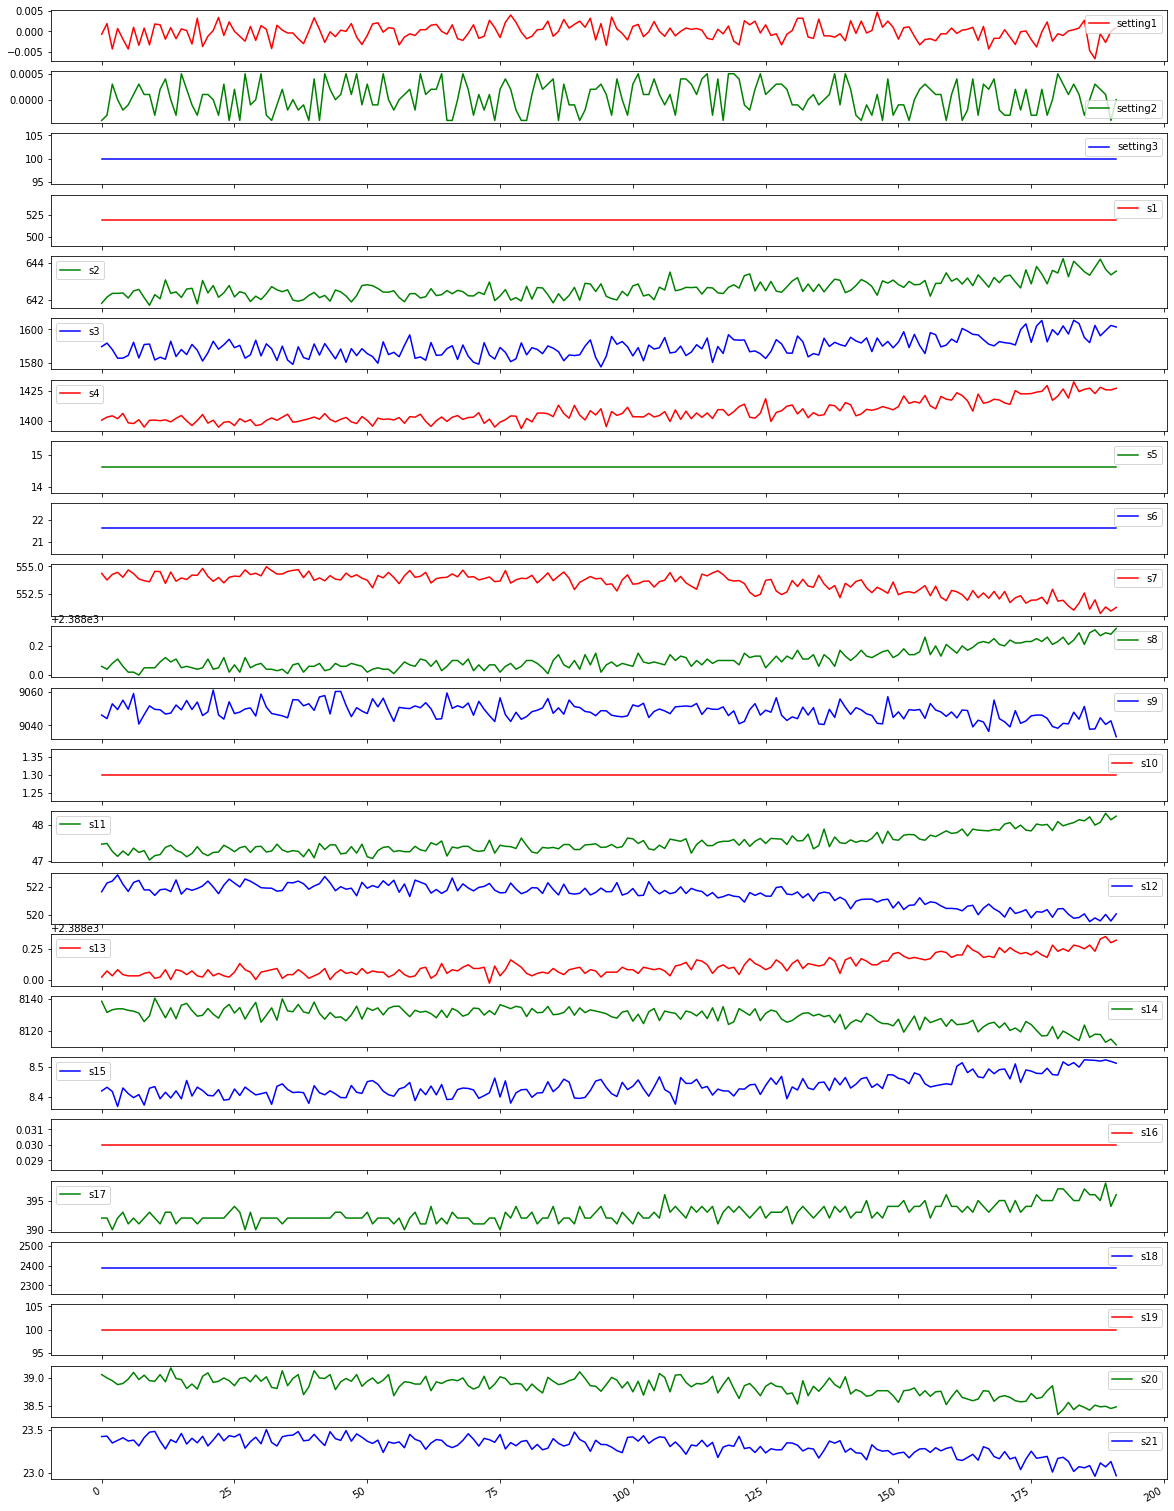

In [ ]:
### plotting sensor data for engine ID ###
engine_id = train_df[train_df['id'] == 1]

ax1 = engine_id[train_df.columns[2:]].plot(subplots=True, sharex=True, figsize=(20,30),color=('red','green','blue'))

In [ ]:

test_df = pd.read_csv('./PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
print('#id:',len(test_df.id.unique()))
print(test_df.shape)
test_df.head(3)

#id: 100
(13096, 26)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.2,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.5,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.5,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166


In [ ]:

truth_df = pd.read_csv('./PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
truth_df.columns = ['more']
truth_df = truth_df.set_index(truth_df.index + 1)

print(truth_df.shape)
truth_df.head(3)

(100, 1)


,more
1,112
2,98
3,69


In [ ]:

train_df['RUL']=train_df.groupby(['id'])['cycle'].transform(max)-train_df['cycle']
train_df.RUL[0:10]

0    191
1    190
2    189
3    188
4    187
5    186
6    185
7    184
8    183
9    182
Name: RUL, dtype: int64

In [ ]:

w1 = 45
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

In [ ]:


def scale(df):
    #return (df - df.mean())/df.std()
    return (df - df.min())/(df.max()-df.min())

for col in train_df.columns:
    if col[0] == 's':
        train_df[col] = scale(train_df[col])
#     elif col == 'cycle':
#         train_df['cycle_norm'] = scale(train_df[col])
        
train_df = train_df.dropna(axis=1)
train_df.head()

,id,cycle,setting1,setting2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,RUL,label1,label2
0,1,1,0.459770,0.166667,0.183735,0.406802,0.309757,1.0,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,191,0,0
1,1,2,0.609195,0.250000,0.283133,0.453019,0.352633,1.0,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,190,0,0
2,1,3,0.252874,0.750000,0.343373,0.369523,0.370527,1.0,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,189,0,0
3,1,4,0.540230,0.500000,0.343373,0.256159,0.331195,1.0,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,188,0,0
4,1,5,0.390805,0.333333,0.349398,0.257467,0.404625,1.0,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,187,0,0


In [ ]:

truth_df['max'] = test_df.groupby('id')['cycle'].max() + truth_df['more']
test_df['RUL'] = [truth_df['max'][i] for i in test_df.id] - test_df['cycle']

In [ ]:

test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

In [ ]:


for col in test_df.columns:
    if col[0] == 's':
        test_df[col] = scale(test_df[col])
#     elif col == 'cycle':
#         test_df['cycle_norm'] = scale(test_df[col])
        
test_df = test_df.dropna(axis=1)
test_df.tail(5000)[:1]

,id,cycle,setting1,setting2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,RUL,label1,label2
8096,62,155,0.575,0.153846,0.315457,0.480914,0.272207,1.0,0.65121,0.219512,0.27433,0.232877,0.675799,0.209302,0.339971,0.342282,0.5,0.654545,0.614013,131,0,0


In [ ]:
test_df['s3'].values.shape[0]

13096

In [ ]:
sequence_length = 50

def gen_sequence(id_df, seq_length, seq_cols):

    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
def gen_labels(id_df, seq_length, label):

    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

In [ ]:
sequence_cols = []
for col in train_df.columns:
    if col[0] == 's':
        sequence_cols.append(col)
#sequence_cols.append('cycle_norm')
print(sequence_cols)

['setting1', 'setting2', 's2', 's3', 's4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']


In [ ]:
x_train, x_test = [], []
for engine_id in train_df.id.unique():
    for sequence in gen_sequence(train_df[train_df.id==engine_id], sequence_length, sequence_cols):
        x_train.append(sequence)
    for sequence in gen_sequence(test_df[test_df.id==engine_id], sequence_length, sequence_cols):
        x_test.append(sequence)
          
x_train = np.asarray(x_train)
x_test = np.asarray(x_test)

print("X_Train shape:", x_train.shape)
print("X_Test shape:", x_test.shape)

X_Train shape: (15631, 50, 17)
X_Test shape: (8162, 50, 17)


In [ ]:
x_test.shape

(8162, 50, 17)

In [ ]:
y_train, y_test = [], []
for engine_id in train_df.id.unique():
    for label in gen_labels(train_df[train_df.id==engine_id], sequence_length, ['label2'] ):
        y_train.append(label)
    for label in gen_labels(test_df[test_df.id==engine_id], sequence_length, ['label2']):
        y_test.append(label)
print(y_test,engine_id)
print(type(y_test))   
y_train = np.asarray(y_train).reshape(-1,1)
y_test = np.asarray(y_test).reshape(-1,1)


print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

[array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64),

In [ ]:
y_test

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]], dtype=int64)

In [ ]:
y_train = to_categorical(y_train)
print(y_train.shape)

y_test = to_categorical(y_test)
print(y_test.shape)

(15631, 3)
(8162, 3)


In [ ]:
uniques, ids = np.unique(y_test, return_inverse=True)

In [ ]:
len(np.argmax(y_test, axis=1, out=None))

8162

In [ ]:
def rec_plot(s, eps=0.10, steps=10):
    d = pdist(s[:,None])
    d = np.floor(d/eps)
    d[d>steps] = steps
    Z = squareform(d)
    return Z

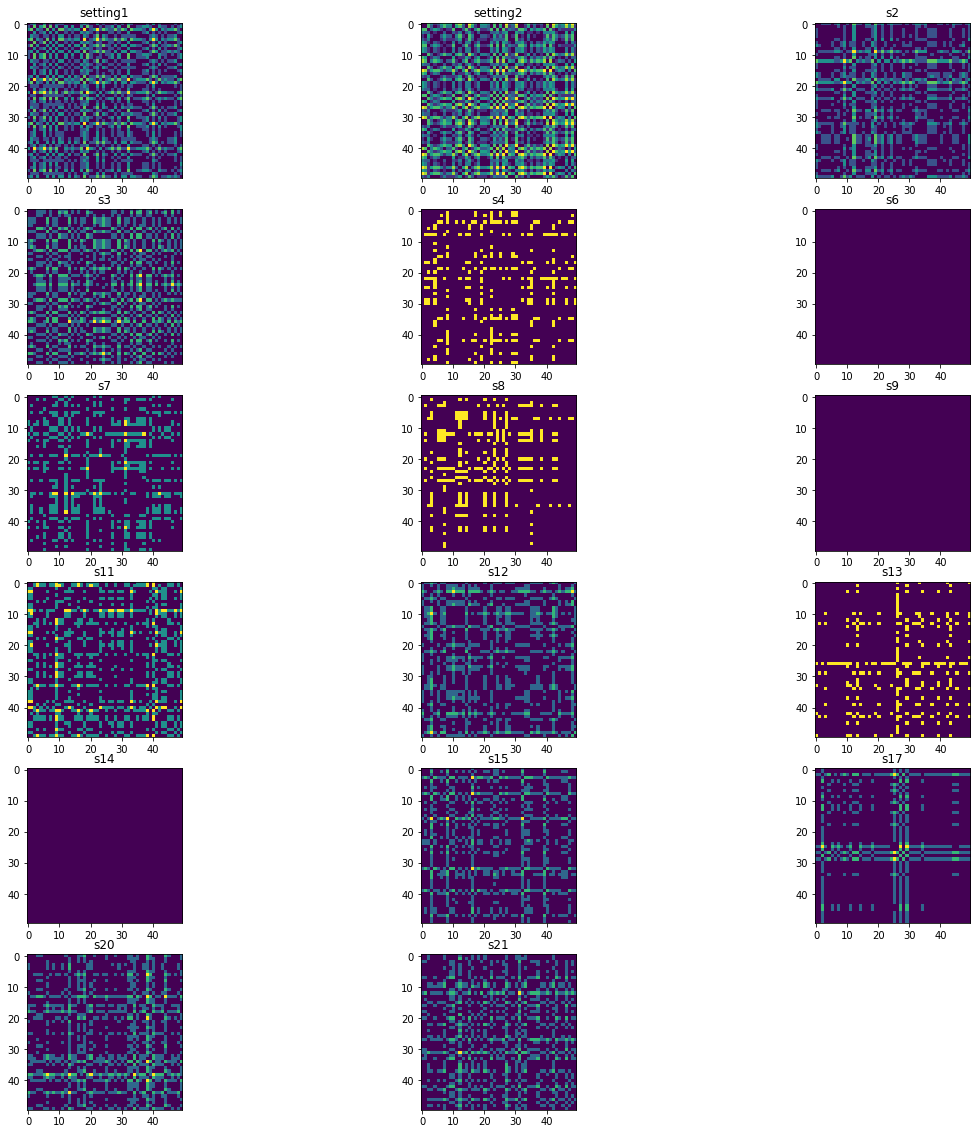

In [ ]:
plt.figure(figsize=(20,20))
for i in range(0,17):
    
    plt.subplot(6, 3, i+1)    
    rec = rec_plot(x_train[0,:,i])
    plt.imshow(rec)
    plt.title(sequence_cols[i])
plt.show()

In [ ]:
x_train_img = np.apply_along_axis(rec_plot, 1, x_train).astype('float16')
print(x_train_img.shape)

x_test_img = np.apply_along_axis(rec_plot, 1, x_test).astype('float16')
print(x_test_img.shape)

(15631, 50, 50, 17)
(8162, 50, 50, 17)


In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 17),padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(tf.keras.layers.Reshape((32,-1)))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dense(256, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

#model = tf.expand_dims(model, axis=-1)


#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 50, 50, 32)        4928      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 22, 22, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 20, 20, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 10, 64)       

In [ ]:
#y_test = to_categorical(test_df['label2'].values.reshape(len(test_df['label2'].values),1))

In [ ]:
#y_train=y_test

In [ ]:
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)


es = EarlyStopping(monitor='val_accuracy', mode='auto', restore_best_weights=True, verbose=1, patience=6)

model.fit(x_train_img, y_train, batch_size=512, epochs=25, callbacks=[es],
          validation_split=0.2, verbose=2)

Epoch 1/25
25/25 - 6s - loss: 0.8079 - accuracy: 0.6825 - val_loss: 0.5667 - val_accuracy: 0.7637
Epoch 2/25
25/25 - 2s - loss: 0.3823 - accuracy: 0.8406 - val_loss: 0.2772 - val_accuracy: 0.8999
Epoch 3/25
25/25 - 3s - loss: 0.2878 - accuracy: 0.8765 - val_loss: 0.2394 - val_accuracy: 0.9031
Epoch 4/25
25/25 - 3s - loss: 0.2519 - accuracy: 0.8915 - val_loss: 0.2344 - val_accuracy: 0.9005
Epoch 5/25
25/25 - 3s - loss: 0.2316 - accuracy: 0.9011 - val_loss: 0.2422 - val_accuracy: 0.8916
Epoch 6/25
25/25 - 2s - loss: 0.2212 - accuracy: 0.9051 - val_loss: 0.2209 - val_accuracy: 0.9041
Epoch 7/25
25/25 - 3s - loss: 0.2138 - accuracy: 0.9068 - val_loss: 0.2209 - val_accuracy: 0.9044
Epoch 8/25
25/25 - 3s - loss: 0.1986 - accuracy: 0.9165 - val_loss: 0.2333 - val_accuracy: 0.9025
Epoch 9/25
25/25 - 3s - loss: 0.1876 - accuracy: 0.9157 - val_loss: 0.2400 - val_accuracy: 0.8983
Epoch 10/25
25/25 - 3s - loss: 0.1811 - accuracy: 0.9214 - val_loss: 0.2276 - val_accuracy: 0.9015
Epoch 11/25
25/25 -

In [ ]:
test_df.values.reshape(13096, 22)

(13096, 22)

In [ ]:
x_test_img = np.apply_along_axis(rec_plot, 1, test_df.values).astype('float16')
print(x_test_img.shape)

(13096, 22, 22)


In [ ]:
x_test_img.reshape(13096, 22, 22,1)

(13096, 22, 22, 1)

In [ ]:
model.save('cnn_lstm.h5')

In [ ]:
from keras.models import load_model

model = load_model('cnn_lstm.h5')
model.evaluate(x_test_img, y_test, verbose=2)

256/256 - 2s - loss: 0.5056 - accuracy: 0.8402


[0.5055975914001465, 0.8402352333068848]

# END

In [ ]:
#save as .py


import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist,squareform
from keras.models import load_model
model = load_model('cnn.h5')
sequence_length = 50
test_df = pd.read_csv('./PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
print('#id:',len(test_df.id.unique()))
print(test_df.shape)
for col in test_df.columns:
    if col[0] == 's':
        test_df[col] = scale(test_df[col])
#     elif col == 'cycle':
#         test_df['cycle_norm'] = scale(test_df[col])
        
test_df = test_df.dropna(axis=1)

sequence_cols = []
for col in test_df.columns:
    if col[0] == 's':
        sequence_cols.append(col)
#sequence_cols.append('cycle_norm')
print(sequence_cols)

def gen_sequence(id_df, seq_length, seq_cols):

    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
def rec_plot(s, eps=0.10, steps=10):
    d = pdist(s[:,None])
    d = np.floor(d/eps)
    d[d>steps] = steps
    Z = squareform(d)
    return Z

x_train, x_test = [], []
for engine_id in test_df.id.unique():
    for sequence in gen_sequence(test_df[test_df.id==engine_id], sequence_length, sequence_cols):
        x_test.append(sequence)
x_test = np.asarray(x_test)

print("X_Test shape:", x_test.shape)
x_test_img = np.apply_along_axis(rec_plot, 1, x_test).astype('float16')
print(x_test_img.shape)
          

k=model.predict(x_test_img)

#id: 100
(13096, 26)
['setting1', 'setting2', 's2', 's3', 's4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']
X_Test shape: (8162, 50, 17)
(8162, 50, 50, 17)


In [ ]:
ar=np.argmax(np.round(k.astype('float32')),axis=1)

In [ ]:
def gen_labels(id_df, seq_length, label):

    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

id_l = []
for engine_id in test_df.id.unique():
    for label in gen_labels(test_df[test_df.id==engine_id], sequence_length, ['id']):
        id_l.append(label)
print(type(y_test))   
id_l = np.asarray(id_l).reshape(-1,1)



<class 'numpy.ndarray'>


In [ ]:
df=pd.DataFrame(id_l)
df['arr']=ar

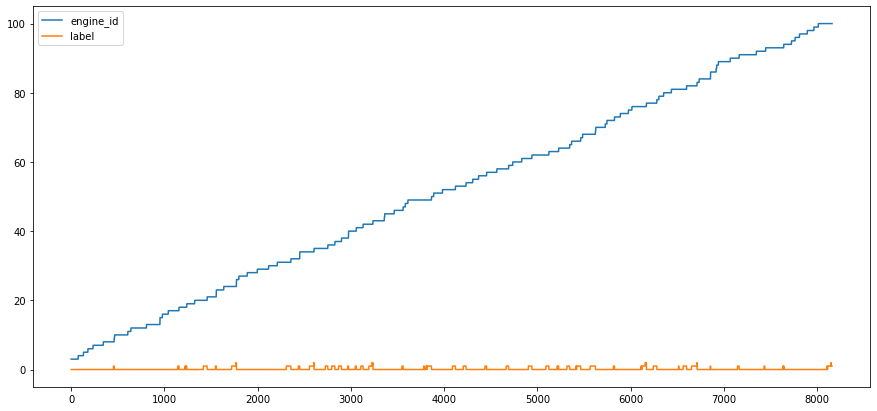

In [ ]:
df.plot(figsize=(15,7))

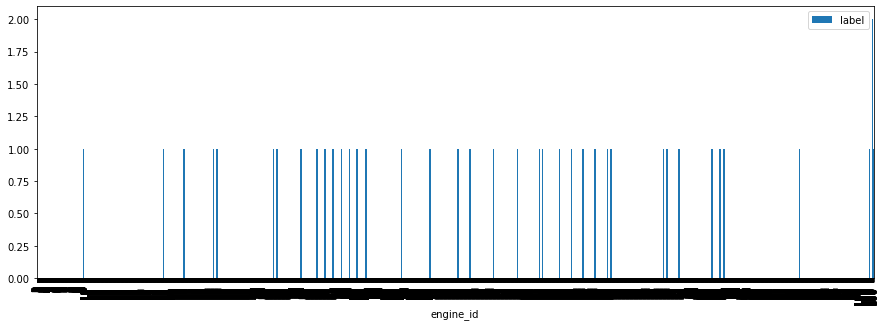

In [ ]:
#df.columns=['engine_id','label']
df.plot(x='engine_id',y='label',figsize=(15,5), kind="bar")

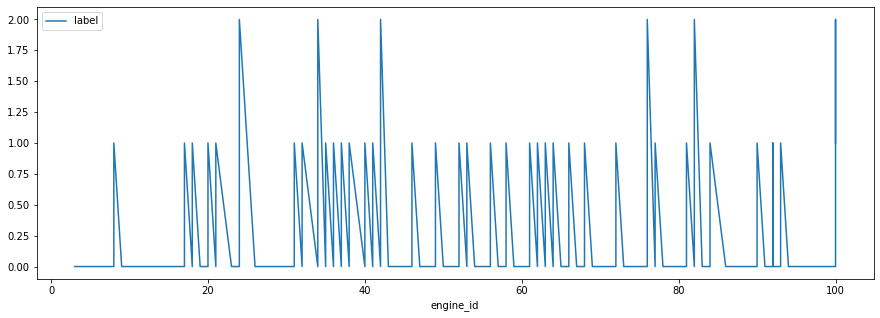

In [ ]:
df.plot(x='engine_id',y='label',figsize=(15,5))

In [ ]:
test_df['label']=pd.Series(ar)

,id,cycle,setting1,setting2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,label
0,1,1,0.65625,0.692308,0.596215,0.421968,0.282214,1.0,0.608871,0.365854,0.196475,0.273973,0.534247,0.325581,0.152259,0.347076,0.375,0.500000,0.620099,0.0
1,1,2,0.34375,0.230769,0.182965,0.504025,0.225240,1.0,0.800403,0.292683,0.229042,0.479452,0.634703,0.395349,0.277907,0.227709,0.500,0.645455,0.645718,0.0
2,1,3,0.53125,0.538462,0.419558,0.464814,0.346130,1.0,0.651210,0.390244,0.248506,0.479452,0.591324,0.325581,0.192892,0.533557,0.500,0.700000,0.681104,0.0
3,1,4,0.77500,0.461538,0.413249,0.391587,0.449867,1.0,0.643145,0.341463,0.159080,0.328767,0.456621,0.372093,0.217896,0.282359,0.250,0.627273,0.620382,0.0
4,1,5,0.60000,0.461538,0.435331,0.471306,0.357974,1.0,0.661290,0.292683,0.153410,0.349315,0.632420,0.325581,0.187891,0.337009,0.125,0.618182,0.676008,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.81875,0.461538,0.665615,0.789665,0.641209,1.0,0.510081,0.317073,0.902989,0.609589,0.299087,0.255814,0.935703,0.664909,0.625,0.309091,0.370842,NaN
13092,100,195,0.44375,0.384615,0.659306,0.692028,0.769042,1.0,0.471774,0.390244,0.890038,0.547945,0.381279,0.465116,0.914003,0.567593,0.750,0.236364,0.483652,NaN
13093,100,196,0.47500,0.230769,0.728707,0.626071,0.458036,1.0,0.435484,0.536585,0.937011,0.527397,0.410959,0.348837,0.971066,0.594919,0.750,0.281818,0.381741,NaN
13094,100,197,0.27500,0.538462,0.671924,0.673851,0.714111,1.0,0.502016,0.439024,0.952644,0.554795,0.445205,0.441860,1.000000,0.662991,0.750,0.318182,0.473461,NaN


In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


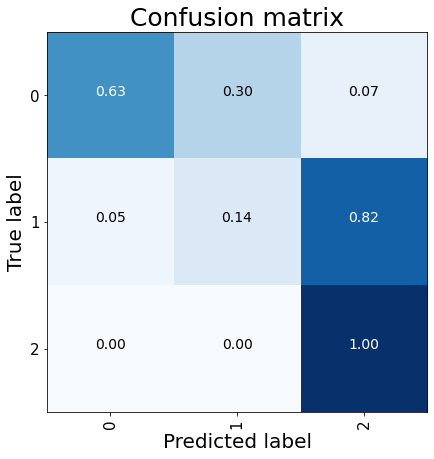

In [ ]:
cnf_matrix = confusion_matrix(np.where(y_test != 0)[1], model.predict_classes(x_test_img))
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=np.unique(np.where(y_test != 0)[1]), title="Confusion matrix")
plt.show()